In [162]:
import nltk
import regex as re
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# For the error
# OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

#import en_core_web_sm
#nlp = en_core_web_sm.load()

#!python -m spacy download en_core_web_sm

In [163]:
with open('halo.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
# Split text into separate lines by newline characters
lines = text.splitlines(keepends=False)

re_ws = re.compile(r'\s+')

# Replace all whitespace character like \t and \s with a single space
lines = [re_ws.sub(' ', line) for line in lines]

# Split into sentences
sentences = [sent for line in lines for sent in nltk.sent_tokenize(line)]

sentence_counter = collections.Counter()

for sent in sentences:
    sentence_counter[sent] += 1

sentences = [sent for sent in sentences if sentence_counter[sent] == 1]

#for sent, count in sentence_counter.most_common():
#    print(count, sent)

# Tokenize each sentence
re_split = re.compile("\s|(?<!\d)[,.](?!\d)")
sentences = [re_split.split(sent) for sent in sentences]

# Filter out non-alphabetic tokens
re_alph = re.compile(r"^[a-zA-Z']+$")
is_alpha = lambda word: re_alph.match(word) is not None

sentences = [[word.lower() for word in sentence if (is_alpha(word) and len(word) > 1)] for sentence in sentences]

# Filter out single-word sentences
sentences = [sentence for sentence in sentences if len(sentence) > 1]

# Extract single words and remove possesives
re_poss = re.compile(r"('s|s')$")
filtered_sentences = [[re_poss.sub('', word) for word in sentence if word not in stop_words] for sentence in sentences]

all_words = [word for sentence in filtered_sentences for word in sentence]
num_words = len(all_words)

# Rejoin sentences
#sentences = [' '.join(sentence) for sentence in sentences]

joined_sentences = [' '.join(sentence) for sentence in sentences]

doc = ' '.join(joined_sentences)

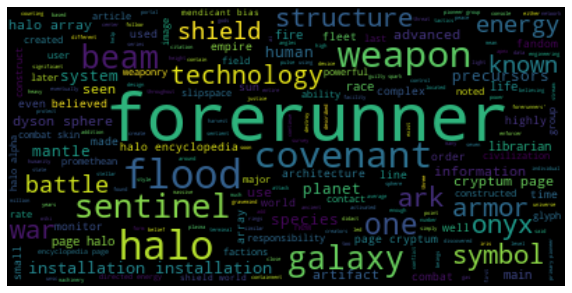

In [164]:
import collections

num_words = 0
counter = collections.Counter()

for sentence in filtered_sentences:
    for word in sentence:
        counter[word] += 1
        num_words += 1

unique_words = list(counter.keys())

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(collocations=True).generate(doc)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [165]:
# https://medium.com/@muddaprince456/categorizing-and-pos-tagging-with-nltk-python-28f2bc9312c3

types_noun = ('NN', 'NNS', 'NNP', 'NNPS')
types_adj_noun = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')

def filter_unigrams(word):
    if word in stop_words:
        return False
    tags = nltk.pos_tag([word])
    return tags[0][1] in types_noun

def filter_bigrams(ngram):
    for word in ngram:
        if word in stop_words:
            return False
    tags = nltk.pos_tag(ngram)   
    return tags[1][1] in types_noun

def filter_trigrams(ngram):
    tags = nltk.pos_tag(ngram)   
    return tags[0][1] in types_adj_noun and tags[2][1] in types_adj_noun

def filter_quadgrams(ngram):
    tags = nltk.pos_tag(ngram)   
    return tags[0][1] in types_adj_noun and tags[3][1] in types_adj_noun

In [166]:
# use to find bigrams, which are pairs of words 
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures, QuadgramAssocMeasures

bigram_finder = BigramCollocationFinder.from_documents(sentences) 
trigram_finder = TrigramCollocationFinder.from_documents(sentences) 
quadgram_finder = QuadgramCollocationFinder.from_documents(sentences) 

# score_fn:
# raw_freq, student_t, chi_sq, likelihood_ratio, pmi

top_n = 100

df1 = pd.DataFrame({'entry': counter.keys(), 'freq': counter.values()})
df1 = df1.sort_values(by='freq', ascending=False)
df1 = df1.head(top_n)
df1 = df1[df1['entry'].map(lambda x: filter_unigrams(x))]

bigram_tuples = bigram_finder.score_ngrams(BigramAssocMeasures.raw_freq)
df2 = pd.DataFrame(bigram_tuples, columns=['entry','score'])
df2 = df2.sort_values(by='score', ascending=False)
df2 = df2.head(top_n)
df2 = df2[df2['entry'].map(lambda x: filter_bigrams(x))]

trigram_tuples = trigram_finder.score_ngrams(TrigramAssocMeasures.raw_freq)
df3 = pd.DataFrame(trigram_tuples, columns=['entry','score'])
df2 = df2.sort_values(by='score', ascending=False)
df3 = df3.head(top_n)
df3 = df3[df3['entry'].map(lambda x: filter_trigrams(x))]

quadgram_tuples = quadgram_finder.score_ngrams(QuadgramAssocMeasures.raw_freq)
df4 = pd.DataFrame(quadgram_tuples, columns=['entry','score'])
df4 = df4.sort_values(by='score', ascending=False)
df4 = df4.head(top_n)
df4 = df4[df4['entry'].map(lambda x: filter_quadgrams(x))]

In [167]:
df1.head(10)

,entry,freq
134,forerunner,91
59,forerunners,65
2,halo,55
184,flood,29
159,covenant,25
63,galaxy,18
814,installation,17
47,weapons,17
7,page,17
582,energy,15


In [168]:
df2.head(10)

,entry,score
17,"(installation, installation)",0.001986
23,"(halo, array)",0.001765
21,"(cryptum, page)",0.001765
30,"(halo, encyclopedia)",0.001324
42,"(forerunner, armor)",0.001103
41,"(encyclopedia, page)",0.001103
40,"(directed, energy)",0.001103
43,"(forerunner, symbols)",0.001103
54,"(forerunner, architecture)",0.000883
58,"(halo, alpha)",0.000883


In [169]:
df3.head(10)

,entry,score
0,"(installation, installation, installation)",0.001765
5,"(halo, encyclopedia, page)",0.001103
6,"(mantle, of, responsibility)",0.000883
8,"(primary, pioneer, group)",0.000883
11,"(battle, of, battle)",0.000662
13,"(ghosts, of, onyx)",0.000662
33,"(art, of, forerunner)",0.000441
52,"(forerunner, combat, skin)",0.000441
53,"(forerunner, fleet, command)",0.000441
57,"(group, of, forerunners)",0.000441


In [170]:
df4.head(10)

,entry,score
0,"(installation, installation, installation, ins...",0.001545
7,"(concept, art, of, forerunner)",0.000441
2359,"(series, and, recurring, image)",0.000221
2360,"(series, of, circular, complex)",0.000221
2364,"(service, that, allows, gamers)",0.000221
2358,"(sergeant, major, avery, johnson)",0.000221
2381,"(shields, of, her, mjolnir)",0.000221
2371,"(sharp, angles, of, metallic)",0.000221
2372,"(sharp, degrees, the, forerunner)",0.000221
2380,"(shields, down, in, gesture)",0.000221


In [171]:
import math

def generate_result(df1, df2, df3, df4, n=50):
    
    res = []
    
    ratio = [0.5, 0.3, 0.2, 0.0]
    
    n1 = math.floor(ratio[0] * n)
    n2 = math.floor(ratio[1] * n)
    n3 = math.floor(ratio[2] * n)
    n4 = math.floor(ratio[3] * n)
    remainder = n - (n1 + n2 + n3 + n4)
    n1 += remainder
    
    res += df1['entry'].iloc[0:n1].tolist()
    res += df2['entry'].iloc[0:n2].apply(' '.join).tolist()
    res += df3['entry'].iloc[0:n3].apply(' '.join).tolist()
    res += df4['entry'].iloc[0:n4].apply(' '.join).tolist()
    
    return res

In [172]:
generate_result(df1, df2, df3, df4, n=100)

['forerunner',
 'forerunners',
 'halo',
 'flood',
 'covenant',
 'galaxy',
 'installation',
 'weapons',
 'page',
 'energy',
 'array',
 'onyx',
 'armor',
 'ark',
 'sentinel',
 'technology',
 'structures',
 'cryptum',
 'combat',
 'battle',
 'shield',
 'precursors',
 'species',
 'war',
 'beams',
 'beam',
 'sentinels',
 'symbols',
 'mantle',
 'group',
 'use',
 'information',
 'weapon',
 'dyson',
 'planet',
 'system',
 'life',
 'fire',
 'fleet',
 'bias',
 'encyclopedia',
 'order',
 'worlds',
 'empire',
 'weaponry',
 'mendicant',
 'shields',
 'artifacts',
 'promethean',
 'alpha',
 'installation installation',
 'halo array',
 'cryptum page',
 'halo encyclopedia',
 'forerunner armor',
 'encyclopedia page',
 'directed energy',
 'forerunner symbols',
 'forerunner architecture',
 'halo alpha',
 'guilty spark',
 'pioneer group',
 'combat skin',
 'mendicant bias',
 'primary pioneer',
 'shield world',
 'pulse beams',
 'installation installation installation',
 'halo encyclopedia page',
 'mantle of re